In [1]:
from ingestion import extract
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [4]:
# Functions
def split_time_series(df, train_size=0.8, val_size=0.1):
    total_size = len(df)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    train = df.iloc[:train_end]
    validation = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, validation, test

def transform_and_scale(df_train, df_val, df_test):
    scaler_train = StandardScaler()
    train_scaled = pd.DataFrame(scaler_train.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
    val_scaled = pd.DataFrame(scaler_train.transform(df_val), columns=df_val.columns, index=df_val.index)
    test_scaled = pd.DataFrame(scaler_train.transform(df_test), columns=df_test.columns, index=df_test.index)
    return train_scaled, val_scaled, test_scaled

def prepare_sequences(df: pd.DataFrame, target_column = "Close", sequence_length = 30):
    """
    Prepares sequences from the DataFrame for LSTM input.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the features and target.
    target_column : str
        The name of the target column.
    sequence_length : int
        The length of the sequences.

    Returns
    -------
    tuple
        The sequences for X (features) and y (target).
    """
    feature_columns = df.columns[df.columns != target_column]
    features = df[feature_columns].values
    target = df[target_column].values

    generator = TimeseriesGenerator(features, target, length=sequence_length, batch_size=1)

    X = []
    y = []

    for X_batch, y_batch in generator:
        X.append(X_batch[0])
        y.append(y_batch[0])

    return np.array(X), np.array(y)

def build_and_compile_model(input_shape):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [5]:
# Load the data
df = pd.read_csv('transformed_data.csv')
df = df.set_index('index')

df.dropna(inplace = True)

In [6]:
# Split the data into train, validation, and test sets
train_df, val_df, test_df = split_time_series(df)

# Apply Standard Scaling to each set
scaler_train = StandardScaler()
scaler_val = StandardScaler()
scaler_test = StandardScaler()

# Fit the scaler on training data and transform all sets
train_scaled = pd.DataFrame(scaler_train.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
val_scaled = pd.DataFrame(scaler_train.transform(val_df), columns=val_df.columns, index=val_df.index)
test_scaled = pd.DataFrame(scaler_train.transform(test_df), columns=test_df.columns, index=test_df.index)

# Prepare sequences for each set
X_train, y_train = prepare_sequences(train_scaled, target_column="Close", sequence_length=30)
X_val, y_val = prepare_sequences(val_scaled, target_column="Close", sequence_length=30)
X_test, y_test = prepare_sequences(test_scaled, target_column="Close", sequence_length=30)


# Build and compile the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_and_compile_model(input_shape)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss (MSE)
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Set a higher number of epochs
    batch_size=32,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

# Evaluate on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/50
49/49 [==============================] - 7s 67ms/step - loss: 0.2516 - val_loss: 1.3173
Epoch 2/50
49/49 [==============================] - 2s 42ms/step - loss: 0.1455 - val_loss: 0.9706
Epoch 3/50
49/49 [==============================] - 2s 46ms/step - loss: 0.1273 - val_loss: 0.8142
Epoch 4/50
49/49 [==============================] - 3s 55ms/step - loss: 0.1241 - val_loss: 1.2401
Epoch 5/50
49/49 [==============================] - 3s 67ms/step - loss: 0.1097 - val_loss: 0.7888
Epoch 6/50
49/49 [==============================] - 3s 53ms/step - loss: 0.1019 - val_loss: 0.6220
Epoch 7/50
49/49 [==============================] - 2s 45ms/step - loss: 0.0901 - val_loss: 0.5854
Epoch 8/50
49/49 [==============================] - 2s 39ms/step - loss: 0.0912 - val_loss: 0.5264
Epoch 9/50
49/49 [==============================] - 2s 51ms/step - loss: 0.0821 - val_loss: 0.4438
Epoch 10/50
49/49 [==============================] - 4s 80ms/step - loss: 0.0800 - val_loss: 0.6605
Epoch 11/

Mean Squared Error: 0.4438447667664775


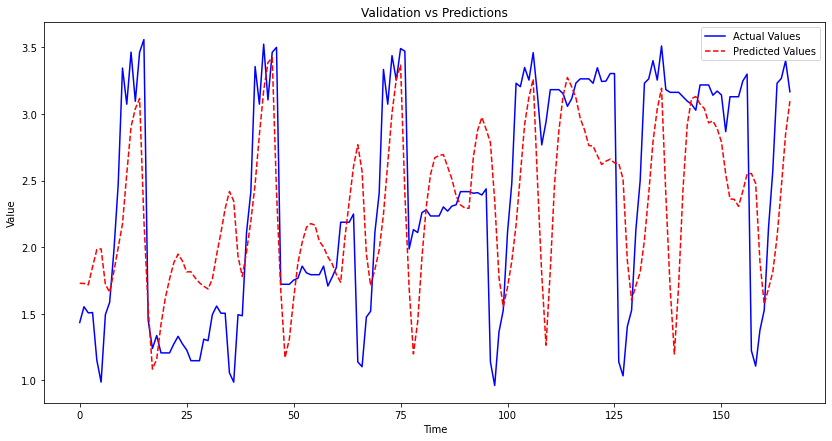

In [7]:
##check mse and plot ##
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Assuming 'loaded_model' is your model and 'X_val' is your validation input data
# and 'y_val' is your actual validation target data.

# Make predictions
predictions = model.predict(X_val)

# Calculate MSE
mse = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error: {mse}")

# Plot validation vs predictions
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(y_val, label='Actual Values', color='blue')

# Plot predicted values
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')

plt.title('Validation vs Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

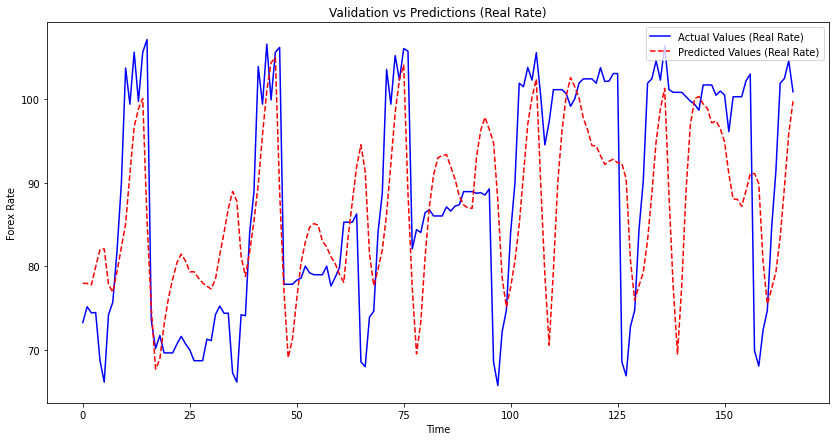

In [8]:
# Perform inverse transformation on the predictions and the actual values
y_val_inverse = scaler_train.inverse_transform(np.column_stack([val_scaled.iloc[30:, :-1], y_val]))
predictions_inverse = scaler_train.inverse_transform(np.column_stack([val_scaled.iloc[30:, :-1], predictions]))

# Extract the 'Close' column (assuming it's the last column after inverse transforming)
y_val_real = y_val_inverse[:, -1]
predictions_real = predictions_inverse[:, -1]

# Plot validation vs predictions with real rates
plt.figure(figsize=(14, 7))

# Plot actual values (real rates)
plt.plot(y_val_real, label='Actual Values (Real Rate)', color='blue')

# Plot predicted values (real rates)
plt.plot(predictions_real, label='Predicted Values (Real Rate)', color='red', linestyle='--')

plt.title('Validation vs Predictions (Real Rate)')
plt.xlabel('Time')
plt.ylabel('Forex Rate')
plt.legend()
plt.show()

Mean Squared Error: 5.0760110438269805


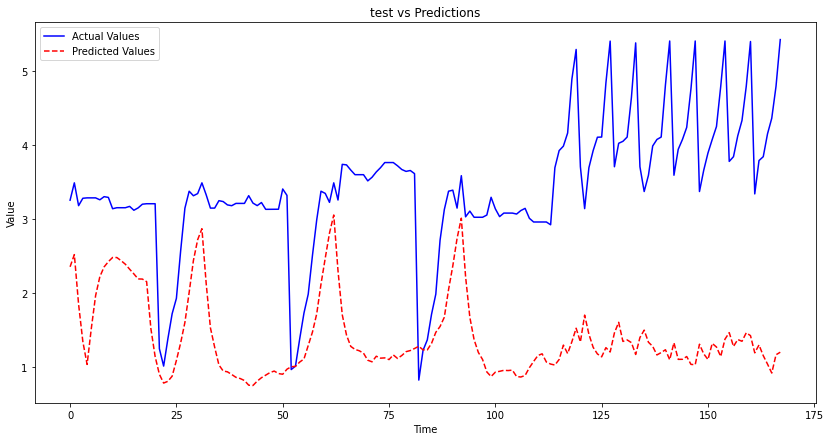

In [10]:
##check mse and plot ##
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Assuming 'loaded_model' is your model and 'X_val' is your validation input data
# and 'y_val' is your actual validation target data.

# Make predictions
predictions = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Plot validation vs predictions
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(y_test, label='Actual Values', color='blue')

# Plot predicted values
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')

plt.title('test vs Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
model.save('my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the H5 file
model = load_model('my_model.h5')